### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Friday, Mar 27th at 11.59pm CST
### #BS *Saturday, Mar 28th*
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

#### Part 1

In [1]:
#BS - import the things

import numpy as np
import time
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.stats import norm
from scipy.stats import uniform
import emcee
from numpy import inf


# BS - load the data
data = np.load('/Users/smithwj/Box Sync/Astrostatistics/astr_8070_s21/coursework/homeworks/hw_data/hw5_data_1.npy')

# BS - separate the data into three arrays
data = np.transpose(data)

print(np.shape(data))
times, fluxes, flux_uncerts = data


(3, 100)


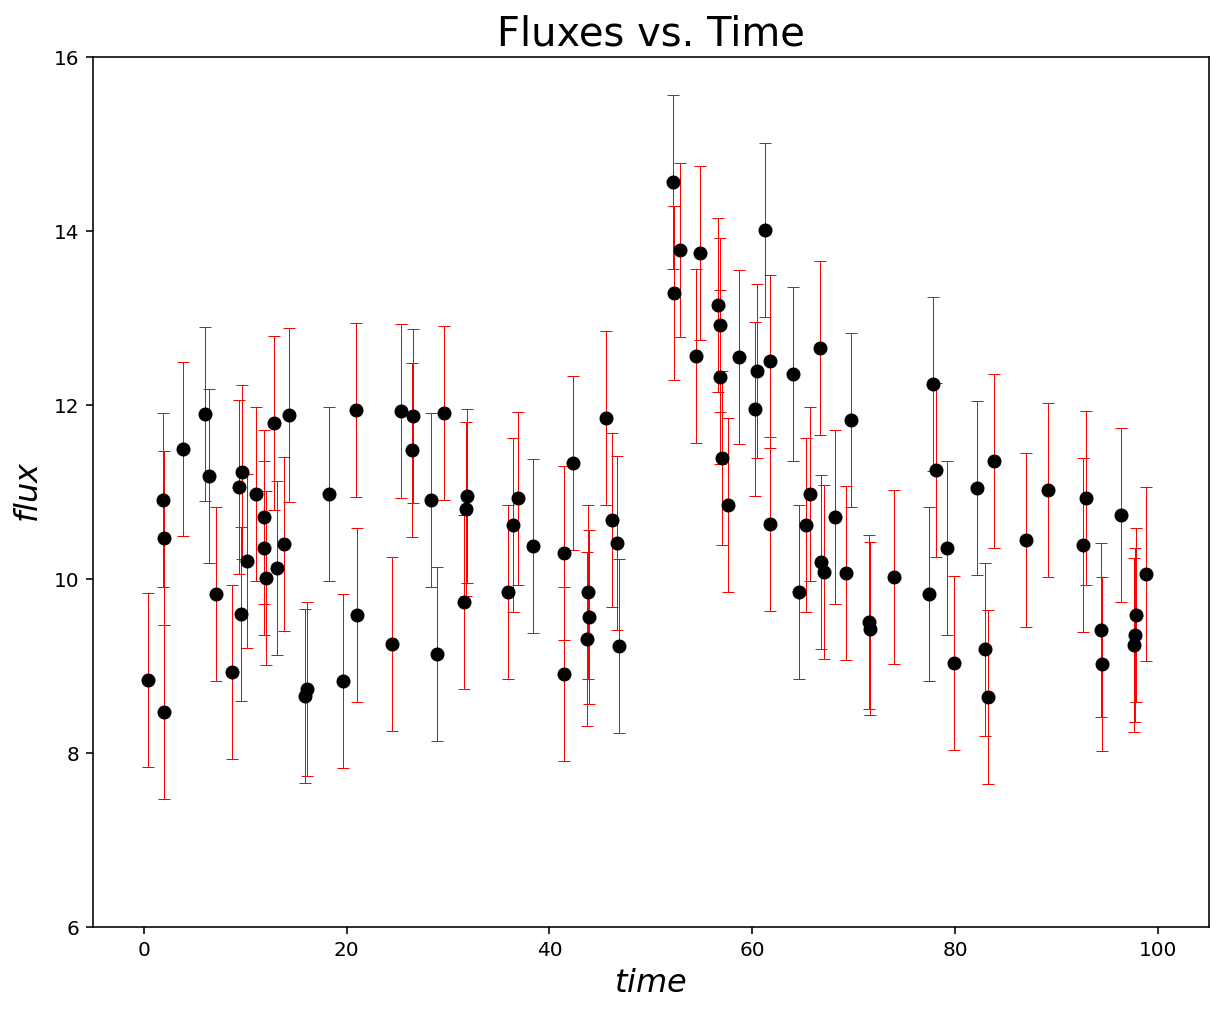

In [2]:
# BS - plot the fluxes over time with their associates errors

plt.subplots(figsize=(10,8))
plt.ylim(6, 16)
plt.xlim(-5, 105)
plt.title("Fluxes vs. Time", fontsize = 20)
plt.xlabel(r"$time$", fontsize = 16)
plt.ylabel(r"$flux$", fontsize = 16)
plt.errorbar(times, fluxes, yerr = flux_uncerts, fmt='ok',
             markersize=6, ecolor='red', elinewidth=0.5, capsize=3, capthick=0.5)
plt.show()


#### Part 2

In [3]:
#BS - make the burst model function

def burst_model(t, b, t_0, A, alpha):
    
    '''Burst model function fits fluxes to time observations following the burst model
    
    arguments:
    
        t = array of time observations
    
        b = background amplitude (single value)
        t_0 = burst epoch (single value)
        A = burst amplitude (single value)
        alpha = exponential burst die off (single value)
    
    
    returns:
    
        y = array of fluxes 
    
    '''
    
    # BS - create masks the functional jump before and after the burst epoch
    mask_above = (t >= t_0)
    mask_below = (t < t_0)
    
    
    # BS - create an array of zeros
    y = np.zeros(len(t))
    
    # BS - for values of t below burst epoch, flux is equal to background
    # for values of t above burst epoch, flux is fit to exponential function
    y[mask_below] = b
    y[mask_above] = b + A * np.exp(-alpha*(t[mask_above] - t_0))

    return y


# BS = test the burst model function to see if it seems to be working for a set
# of values
# s = burst_model(times, 14, 10, 0.5, 0.03)
# print(s)



# BS - This is the first log-likelihood function I made, but I am not using it for the
# rest of this homework (I use the next function). This function is kept for posterity.
# The main culprit for my MCMC having taken so long for much of this HW appears to be
# the "log_likelihood = sum(norm.logpdf(*args)..." line. The next function does the same
# thing but changes this line to a more "manual" log-likelihood calculation. The MCMC runs
# almost 20 times faster.

def burst_log_likelihood(theta, data, model=burst_model):
    
    '''burst log likelihood takes a single set of burst model parameters, fits it to the
    data using the burst_model function, and calculated the log-likelihood for the model for 
    those given parameters and set of data
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function
        
        data - 3 x N array of time and flux data, in which row 1 is the recorded time, row 2
        is the measured flux, and row 3 is the measured uncertainty in the flux
        
        model = burst model is default
    
    returns:
    
        log_likelihood - the log-likelihood of the specific model parameters and given data
    
    '''
    
    #BS = unpack the input data
    times, flux, f_uncerts = data

    #BS - fit the times and parameters to get predicted fluxes
    flux_fits = model(t = times, b = theta[0], t_0 = theta[1], A = theta[2], alpha = theta[3])

    #BS - calculate the log-likelihood of the model using Gaussian error
    log_likelihood = sum(norm.logpdf(*args) for args in zip(flux, flux_fits, f_uncerts))
    
    return log_likelihood


#BS - This is the faster likelihood function I use for the rest of the HW

def burst_likelihood_fast(theta, data, model=burst_model):
    
    '''burst log likelihood takes a single set of burst model parameters, fits it to the
    data using the burst_model function, and calculated the log-likelihood for the model for 
    those given parameters and set of data
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function
        
        data - 3 x N array of time and flux data, in which row 1 is the recorded time, row 2
        is the measured flux, and row 3 is the measured uncertainty in the flux
        
        model = burst model is default
    
    returns:
    
        ln_L - the log-likelihood of the specific model parameters and given data
    
    '''
    
    #BS = unpack the input data
    times, flux, f_uncerts = data
    
    #BS - fit the times and parameters to get predicted fluxes
    flux_fits = model(t = times, b = theta[0], t_0 = theta[1], A = theta[2], alpha = theta[3])
    
    #BS - calculate the log-likelihood of the model using Gaussian error
    ln_L = -np.sum((flux - flux_fits)**2 / (2 * f_uncerts**2))
    
    return ln_L



### Some quick dumb checks to make sure the functions above work OK ###

# BS - a reminder note - theta = [b, t_0, A, alpha]

# BS - a test that the log-likelihood function give me a reasonable log-likelihood 
# for a single set of model parameters

# BS - test_theta:
test_theta = [10, 50, 0.5, 10]   

# BS - calulate the log-likelihood
#burst_likelihood_test = burst_log_likelihood(test_theta, data)
#print(burst_likelihood_test)
#burst_test = burst_likelihood_test(test_theta, data)
#print(burst_test)

#### Part 3

In [4]:
def log_prior(theta):
    
    '''
    Calculates the log_prior for the burst model with the uniform priors given
    
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function
        
    returns:
    
        log_prior - the log of the prior calculated from the combined likelihoods for each of the four 
            parameters
        
    '''
    
    # BS - unpack theta
    b, t_0, A, alpha = theta
    
    # BS - log-prior for b, uniform from 0 to 50
    log_prior_b = uniform.logpdf(b, loc=0, scale=50)
    
    # BS - log-prior for t_0, uniform from 0 to 100
    log_prior_t0 = uniform.logpdf(t_0, loc=0, scale=100)
    
    # BS - log-prior for A, uniform from 0 to 50
    log_prior_A = uniform.logpdf(A, loc=0, scale=50)
    
    
    # BS - log-prior for alpha, uniform from -5 to 5 (for ln(alpha)!)
    
    # BS - my first prior that wasn't working 
    # log_prior_alpha = uniform.logpdf(alpha, loc=-5, scale=10)
    
    # BS - The prior I am going with - NOTE ON PRIOR LOGIC IN MARKUP BELOW
    
    if (alpha >= np.exp(-5)) and (alpha <= np.exp(5)):
        prior_alpha = (0.1*(1/alpha))
        
    else:
        prior_alpha = 0
        
    log_prior_alpha = np.log(prior_alpha)
    
    # BS - sum the logs to get the total log prior
    log_prior = log_prior_b + log_prior_t0 + log_prior_A + log_prior_alpha
    

    return log_prior




def log_posterior(theta, data):
    
    '''
    Caclulates the log_posterior from the (log) model and the (log) prior
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function, to pass to the burst model function and the prior function
        
        data - 3 x N array of time and flux data, in which row 1 is the recorded time, row 2
        is the measured flux, and row 3 is the measured uncertainty in the flux
        
    returns:
    
        log_posterior - the log of the posterior probability for the given data and parameters
        for the specified model and the prior distributions
    
    '''
    
    #log_posterior = burst_log_likelihood(theta, data) + log_prior(theta)
    log_posterior = burst_likelihood_fast(theta, data) + log_prior(theta)
    
    return log_posterior


# BS - quick test to make sure the log_posterior function is working
#test_log_post = log_posterior(test_theta, data)
#print(test_log_post)

My logic for the prior for $\ln\alpha$ was this: 

If
$$\ln(\alpha)\in\mathrm{Uniform}[-5,5]$$
Let:

$$ x = \ln(\alpha) $$

and

$$ y = e^{x} = e^{\ln(\alpha)} = \alpha $$

The uniform probability distribution for $\ln(\alpha)$ is:

$$p(\ln\alpha) = p(x) = \frac{1}{5-(-5)} = 0.1$$

so $p(y) = p(\alpha)$ is:

$$p(y) = \left|\frac{dx}{dy}\right| p(x) = \left|\frac{dy}{dx}\right|^{-1} p(x)$$

Since:

$$ \frac{dy}{dx} = \frac{d}{dx} e^{x} = e^{x} $$

the probability distribution for $\alpha$ becomes:

$$p(\alpha) = p(y) = \frac{1}{e^{x}}p(x) = \frac{1}{y}{0.1} = \frac{1}{\alpha}0.1$$

with bounds now $[e^{-5}, e^{5}]$ instead of $[-5, 5]$. Then I take the log of all of that because I am taking the log prior instead of the prior just like with the other parameters.






SRT: Well done for the probability transformation! This all looks perfect.

In [5]:

# BS - the set up to run emcee MCMC

ndim = 4  # number of parameters in the model
nwalkers = 12  # number of MCMC walkers
burn = 5000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take **for each walker**


# BS - set random seed so MCMC results are reproducable
np.random.seed(0)

# BS - initialize theta - starting guesses for each of the walkers

starting_guesses_b = 50*np.random.random(nwalkers) # random number between 0 and 50 for b for each walker
starting_guesses_t_0 = 100*np.random.random(nwalkers) # random number between 0 and 100 for t0 for each walker
starting_guesses_A = 50*np.random.random(nwalkers) # random number between 0 and 50 for A for each walker
starting_guesses_alpha = np.exp(10*np.random.random(nwalkers)-5) # random number between e^-5 and e^5 for alpha for each walker

starting_guesses = np.transpose(np.array([starting_guesses_b, starting_guesses_t_0, starting_guesses_A, starting_guesses_alpha]))

In [6]:
# BS - time the chain (I was having some issues with how long the MCMC took)
mcmc_startime = time.time()

# BS - the function call where all the work happens: 
# Note - the moves argument has been added. Since I was having so many issues with some of the walkers being stuck
# that wouldn't go away even when the burn and number of steps were stupidly high, I read some of the
# emcee documentation (https://emcee.readthedocs.io/en/stable/tutorials/moves/) and it recommended I try 
# changing this moves argument, so that is what I did!

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, moves=[(emcee.moves.DEMove(), 0.8), (emcee.moves.DESnookerMove(), 0.2),], args=[data])
sampler.run_mcmc(starting_guesses, nsteps)

# BS - print the runtime for the MCMC
mcmc_runtime = (time.time() - mcmc_startime)/60
print("runtime for mcmc is: {:.3} minutes".format(mcmc_runtime))

<ipython-input-4-ba16caf65969>:45: RuntimeWarning: divide by zero encountered in log
  log_prior_alpha = np.log(prior_alpha)
<ipython-input-3-e693bdcb33ad>:34: RuntimeWarning: overflow encountered in exp
  y[mask_above] = b + A * np.exp(-alpha*(t[mask_above] - t_0))
<ipython-input-3-e693bdcb33ad>:118: RuntimeWarning: overflow encountered in square
  ln_L = -np.sum((flux - flux_fits)**2 / (2 * f_uncerts**2))
<ipython-input-3-e693bdcb33ad>:34: RuntimeWarning: overflow encountered in multiply
  y[mask_above] = b + A * np.exp(-alpha*(t[mask_above] - t_0))


runtime for mcmc is: 1.93 minutes


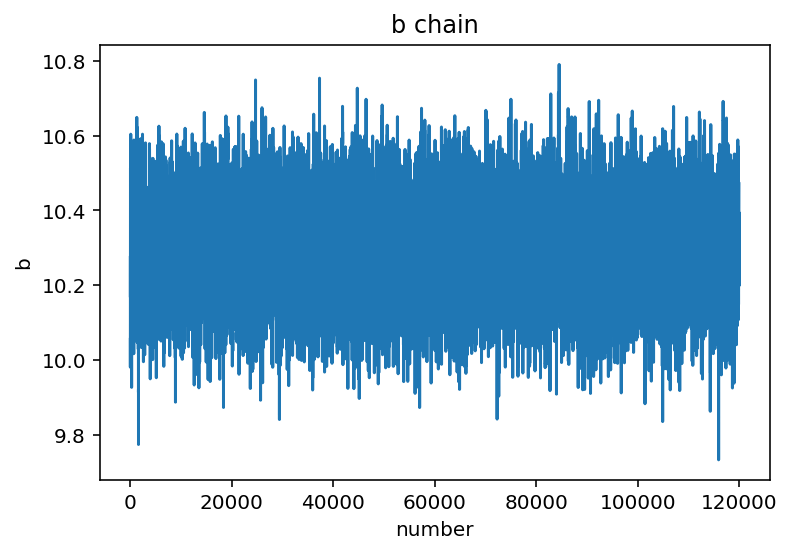

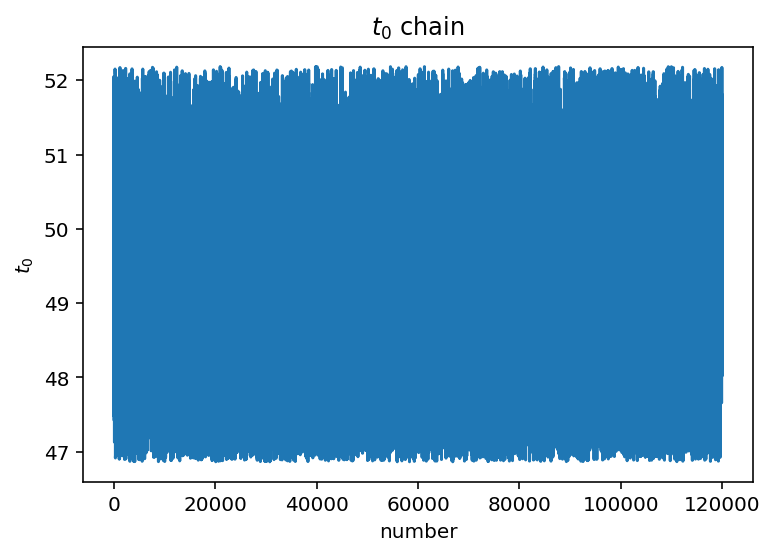

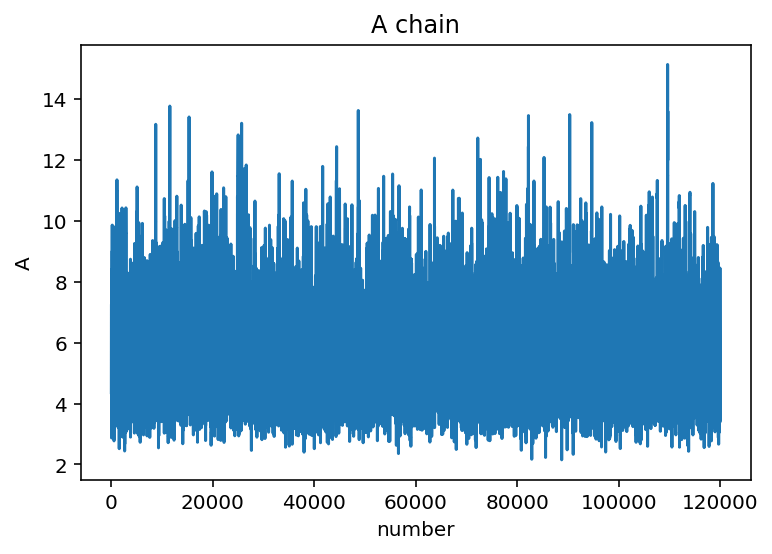

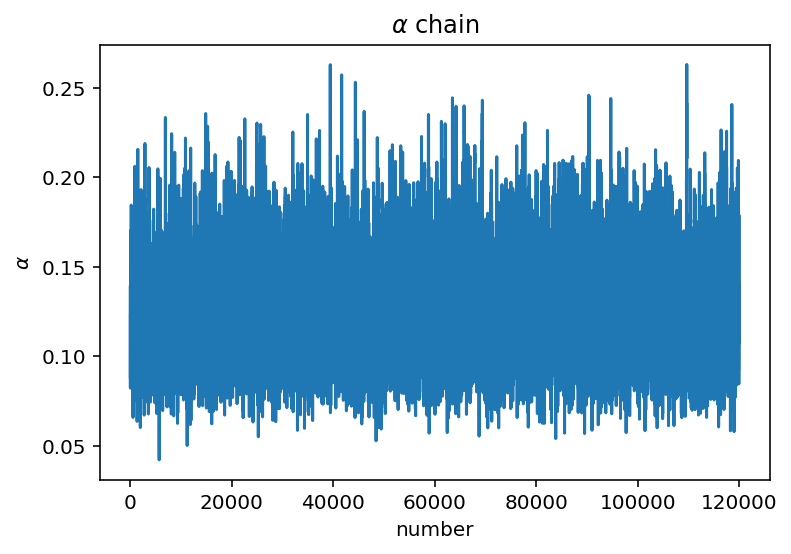

In [7]:
# BS - make the trace plots


emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

chainE = emcee_trace
M = np.shape(chainE)[0]

xgrid = np.linspace(1, M, M)


# BS - b trace
plt.title("b chain")
plt.xlabel("number")
plt.ylabel("b")
plt.plot(xgrid, chainE[:,0])
plt.show()

# BS - t_0 trace
plt.title(r"$t_{0}$ chain")
plt.xlabel("number")
plt.ylabel(r"$t_{0}$")
plt.plot(xgrid, chainE[:,1])
plt.show()

# BS - A trace
plt.title("A chain")
plt.ylabel("A")
plt.xlabel("number")
plt.plot(xgrid, chainE[:,2])
plt.show()

# BS - alpha trace
plt.title(r"$\alpha$ chain")
plt.ylabel(r"$\alpha$")
plt.xlabel("number")
plt.plot(xgrid, chainE[:,3])
plt.show()



#### Part 4

In [8]:
#BS - find the autocorrelation for each of the chains

import acor

print(acor.acor(chainE[:,0]))
print(acor.acor(chainE[:,1]))
print(acor.acor(chainE[:,2]))
print(acor.acor(chainE[:,3]))


(21.501563352874843, 10.294559911756354, 0.0016034810760433894)
(21.99427633469302, 49.23813750959781, 0.020373871415732624)
(28.448031797582466, 5.675154835599638, 0.024121239091729044)
(27.691602267412023, 0.12497537368814692, 0.0004039723347967268)


In [9]:
# BS - thin the chains

thin_b = int(acor.acor(chainE[:,0])[0])
thin_t_0 = int(acor.acor(chainE[:,1])[0])
thin_A = int(acor.acor(chainE[:,2])[0])
thin_alpha = int(acor.acor(chainE[:,3])[0])


# BS - pick the chain with the highest autocorrelation
thin_max = np.max([thin_b, thin_t_0, thin_b, thin_alpha])

# BS - thin each of the chains to the oen with the highest
# autocorrelation
thinned_b_max = chainE[0:-1:thin_max,0]
thinned_t_0_max = chainE[0:-1:thin_max, 1]
thinned_A_max = chainE[0:-1:thin_max, 2]
thinned_alpha_max = chainE[0:-1:thin_max ,3]



SRT: For the last step of thinning, you could have just thinned the overall chain without making those new variables. Be careful with that. You need to preserve the covariances between the parameters. If you had burned. by different amounts in each parameter, or thinned by different amounts, you would have lost that.

#### Part 5

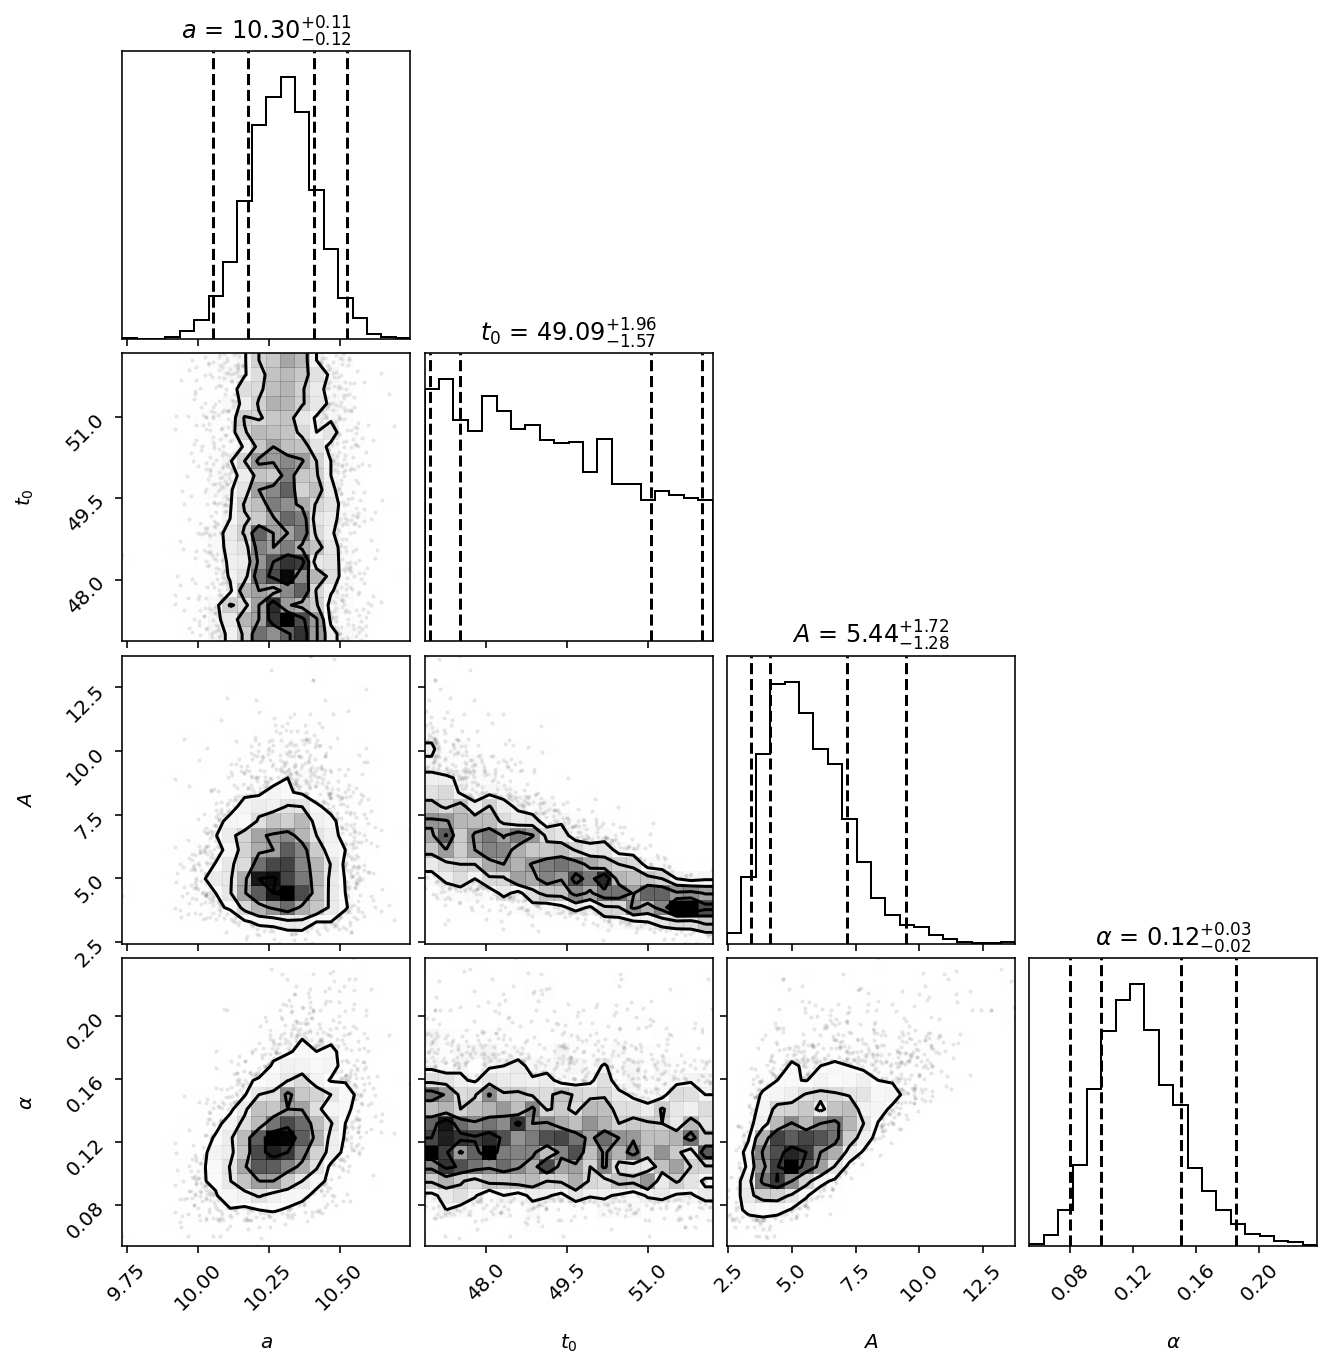

In [10]:
# BS - get it into the form needed for corners
chain_data = np.vstack([thinned_b_max, thinned_t_0_max, thinned_A_max, thinned_alpha_max])
chain_data = np.transpose(chain_data)

#BS - and cornerplot!

import corner
# BS - 68% credible range is 0.16 - 0.84
# 95% credible range is 0.025 - 0.975
fig = corner.corner(chain_data, labels=[r"$a$", r"$t_{0}$", r"$A$", r"$\alpha$"], quantiles=[0.025, 0.16, 0.84, 0.975], show_titles=True)

#### Part 6

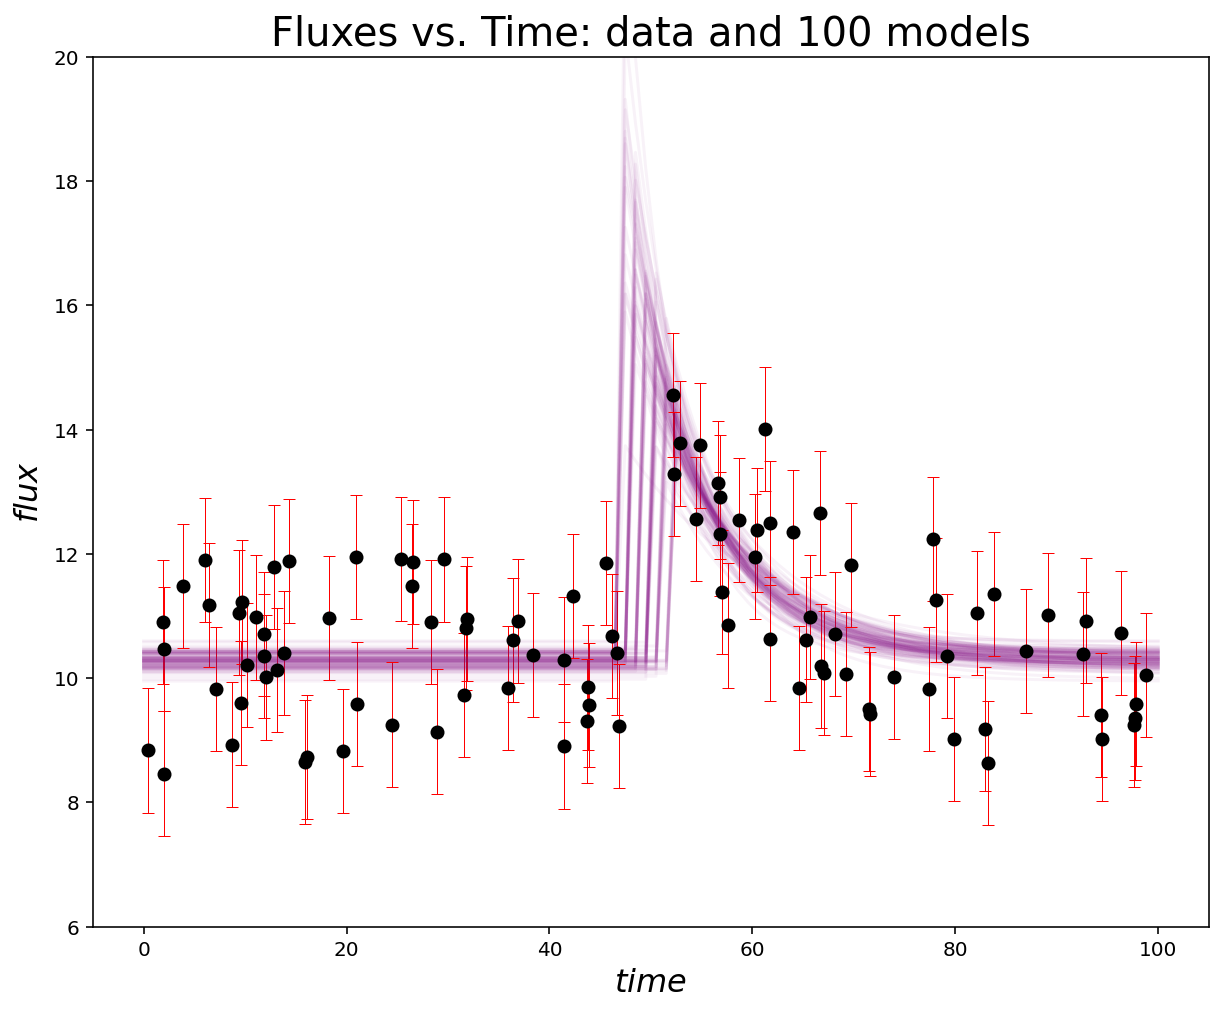

In [11]:
# make 100 randomly chosen samples

np.random.seed(0)
choices_idx = np.random.choice(len(thinned_b_max), 100, replace=False)

# BS - create a grid of times to evaluate each of the randomly chosen models
t_grid = np.linspace(0,100,100)

# BS - make the plot
plt.subplots(figsize=(10,8))

# BS - for each of the models, loop through to evaluate the flux outputs burst model function
# given the set of parameters and plot them

for i in choices_idx:
    
    model_params = np.array([thinned_b_max[i], thinned_t_0_max[i], thinned_A_max[i], thinned_alpha_max[i]])
    pred_fluxes = burst_model(t_grid, thinned_b_max[i], thinned_t_0_max[i], thinned_A_max[i], thinned_alpha_max[i])
    plt.plot(t_grid, pred_fluxes, color='purple', alpha=0.05)


# BS - finish the plot
plt.ylim(6, 20)
plt.xlim(-5, 105)
plt.title("Fluxes vs. Time: data and 100 models", fontsize = 20)
plt.xlabel(r"$time$", fontsize = 16)
plt.ylabel(r"$flux$", fontsize = 16)
plt.errorbar(times, fluxes, yerr = flux_uncerts, fmt='ok',
             markersize=6, ecolor='red', elinewidth=0.5, capsize=3, capthick=0.5)
plt.show()
    
# BS Note: I wanted to add a legend noting that each of the purple lines is a model, but
# I wasn't sure how to do that without adding 100 entries to the legend and probably could
# if I had the time to do enough digging but sleep is also nice.

#### Part 7

In [12]:
# BS - define the Gaussian model


def Gauss_model(t, b, t_0, A, sigma_w):
    
    '''Gauss model function fits fluxes to time observations following the Gauss model
    
    arguments:
    
        t = array of time observations
    
        b = background amplitude (single value)
        t_0 = burst epoch (single value)
        A = burst amplitude (single value)
        sigma_w = exponential burst die off (single value)
    
    
    returns:
    
        y = array of fluxes 
    
    '''
    
    y = b + A*np.exp((-(t - t_0)**2)/(2 * sigma_w**2))
    
    return y


# BS - test the Gauss model just to make sure it works
#test_theta = [10, 50, 10, 1]
#q = Gauss_model(times, test_theta[0], test_theta[1], test_theta[2], test_theta[3])
#print(q)




def Gauss_log_likelihood(theta, data, model=Gauss_model):
    
    '''Gauss log likelihood takes a single set of Gauss model parameters, fits it to the
    data using the Gauss_model function, and calculats the log-likelihood for the model for 
    those given parameters and set of data
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function
        
        data - 3 x N array of time and flux data, in which row 1 is the recorded time, row 2
        is the measured flux, and row 3 is the measured uncertainty in the flux
        
        model = Gauss model is default
    
    returns:
    
        ln_L - the log-likelihood of the specific model parameters and given data
    
    '''
    
    # BS - unpack the data
    times, flux, f_uncerts = data
    
    # BS - fit the times and parameters to the Gauss model and get fluxes
    flux_fits = model(t = times, b=theta[0], t_0=theta[1], A=theta[2], sigma_w=theta[3])
    
    # BS - calculate the log-likelihood of the model using Gaussian error
    ln_L = -np.sum((flux - flux_fits)**2 / (2 * f_uncerts**2))
    
    return ln_L
    
# BS - test the Gauss likelihood function just to make sure it works  
#Gauss_likelihood_test = Gauss_log_likelihood(test_theta, data)
#print(Gauss_likelihood_test)


def Gauss_log_prior(theta):
    
    '''
    Calculates the log_prior for the Gauss model with the uniform priors given
    
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function
        
    returns:
    
        log_prior - the log of the prior calculated from the combined likelihoods for each of the four 
            parameters
        
    '''
    
    # BS - unpack theta
    b, t_0, A, sigma_w = theta
    
    # BS - log-prior for b, uniform from 0 to 50
    log_prior_b = uniform.logpdf(b, loc=0, scale=50)
    
    # BS - log-prior for t_0, uniform from 0 to 100
    log_prior_t0 = uniform.logpdf(t_0, loc=0, scale=100)
    
    # BS - log-prior for A, uniform from 0 to 50
    log_prior_A = uniform.logpdf(A, loc=0, scale=50)
    
    # BS - log-prior for sigma_w, uniform from -2 to 2 (for ln(sigma_w)!)
    # use same logic as for burst model
    
    if (sigma_w >= np.exp(-2)) and (sigma_w <= np.exp(2)):
        prior_sigma_w = (0.25*(1/sigma_w))
        
    else:
        prior_sigma_w = 0
        
    log_prior_sigma_w = np.log(prior_sigma_w)
    
    
    
    #log_prior_alpha = np.log(uniform.pdf(0.1*(1/alpha), loc=np.exp(-5), scale=(np.exp(5) - np.exp(-5))))
    
    log_prior = log_prior_b + log_prior_t0 + log_prior_A + log_prior_sigma_w
    
    return log_prior



def Gauss_log_posterior(theta, data):
    
    '''
    Caclulates the log_posterior from the (log) model and the (log) prior for the Gaussian Model
    
    arguments:
        
        theta - array of model parameters in the form [b, t_0, A, alpha], as defined in the
        burst model function, to pass to the burst model function and the prior function
        
        data - 3 x N array of time and flux data, in which row 1 is the recorded time, row 2
        is the measured flux, and row 3 is the measured uncertainty in the flux
        
    returns:
    
        log_posterior - the log of the posterior probability for the given data and parameters
        for the specified model and the prior distributions
    
    '''

    log_posterior = Gauss_log_likelihood(theta, data) + Gauss_log_prior(theta)
    
    return log_posterior

# BS - test the log-posterior function
#test_log_post_G = Gauss_log_posterior(test_theta, data)  
#print(test_log_post_G)

In [13]:
# BS - hypercube!

def my_prior_burst(cube):
    
    '''Transform samples from the unit cube back to the burst model uniform
    parameter space'''
    
    params = cube.copy()
    
    lo_b = 0
    hi_b = 50
    params[0] = cube[0] * (hi_b - lo_b) + lo_b
    
    lo_A = 0
    hi_A = 50
    params[1] = cube[1] * (hi_A - lo_A) + lo_A
    
    lo_t0 = 0
    hi_t0 = 100
    params[2] = cube[2] * (hi_t0 - lo_t0) + lo_t0
    
    lo_alpha = np.exp(-5)
    hi_alpha = np.exp(5)
    params[3] = cube[3] * (hi_alpha - lo_alpha) + lo_alpha
    
    return params
    
    
    
def my_prior_Gaussian(cube):
    
    '''Transform samples from the unit cube back to the Gauss model uniform
    parameter space'''
    
    params = cube.copy()
    
    lo_b = 0
    hi_b = 50
    params[0] = cube[0] * (hi_b - lo_b) + lo_b
    
    lo_A = 0
    hi_A = 50
    params[1] = cube[1] * (hi_A - lo_A) + lo_A
    
    lo_t0 = 0
    hi_t0 = 100
    params[2] = cube[2] * (hi_t0 - lo_t0) + lo_t0
    
    lo_sigma_w = np.exp(-2)
    hi_sigma_w = np.exp(2)
    params[3] = cube[3] * (hi_sigma_w - lo_sigma_w) + lo_sigma_w
    
    return params
    


In [14]:
import dynesty

# Define the dimensionality of our problem.
ndim = 4

In [15]:
# BS - run the nested sampler on the burst model

sampler_burst = dynesty.NestedSampler(burst_likelihood_fast, my_prior_burst, ndim, logl_args=(data, burst_model))
sampler_burst.run_nested()
sresults = sampler_burst.results

iter: 10773 | +500 | bound: 266 | nc: 1 | ncall: 248029 | eff(%):  4.545 | loglstar:   -inf < -48.766 <    inf | logz: -69.516 +/-  0.285 | dlogz:  0.001 >  0.509                                    

Summary
nlive: 500
niter: 10773
ncall: 248029
eff(%):  4.545
logz: -69.516 +/-  0.285


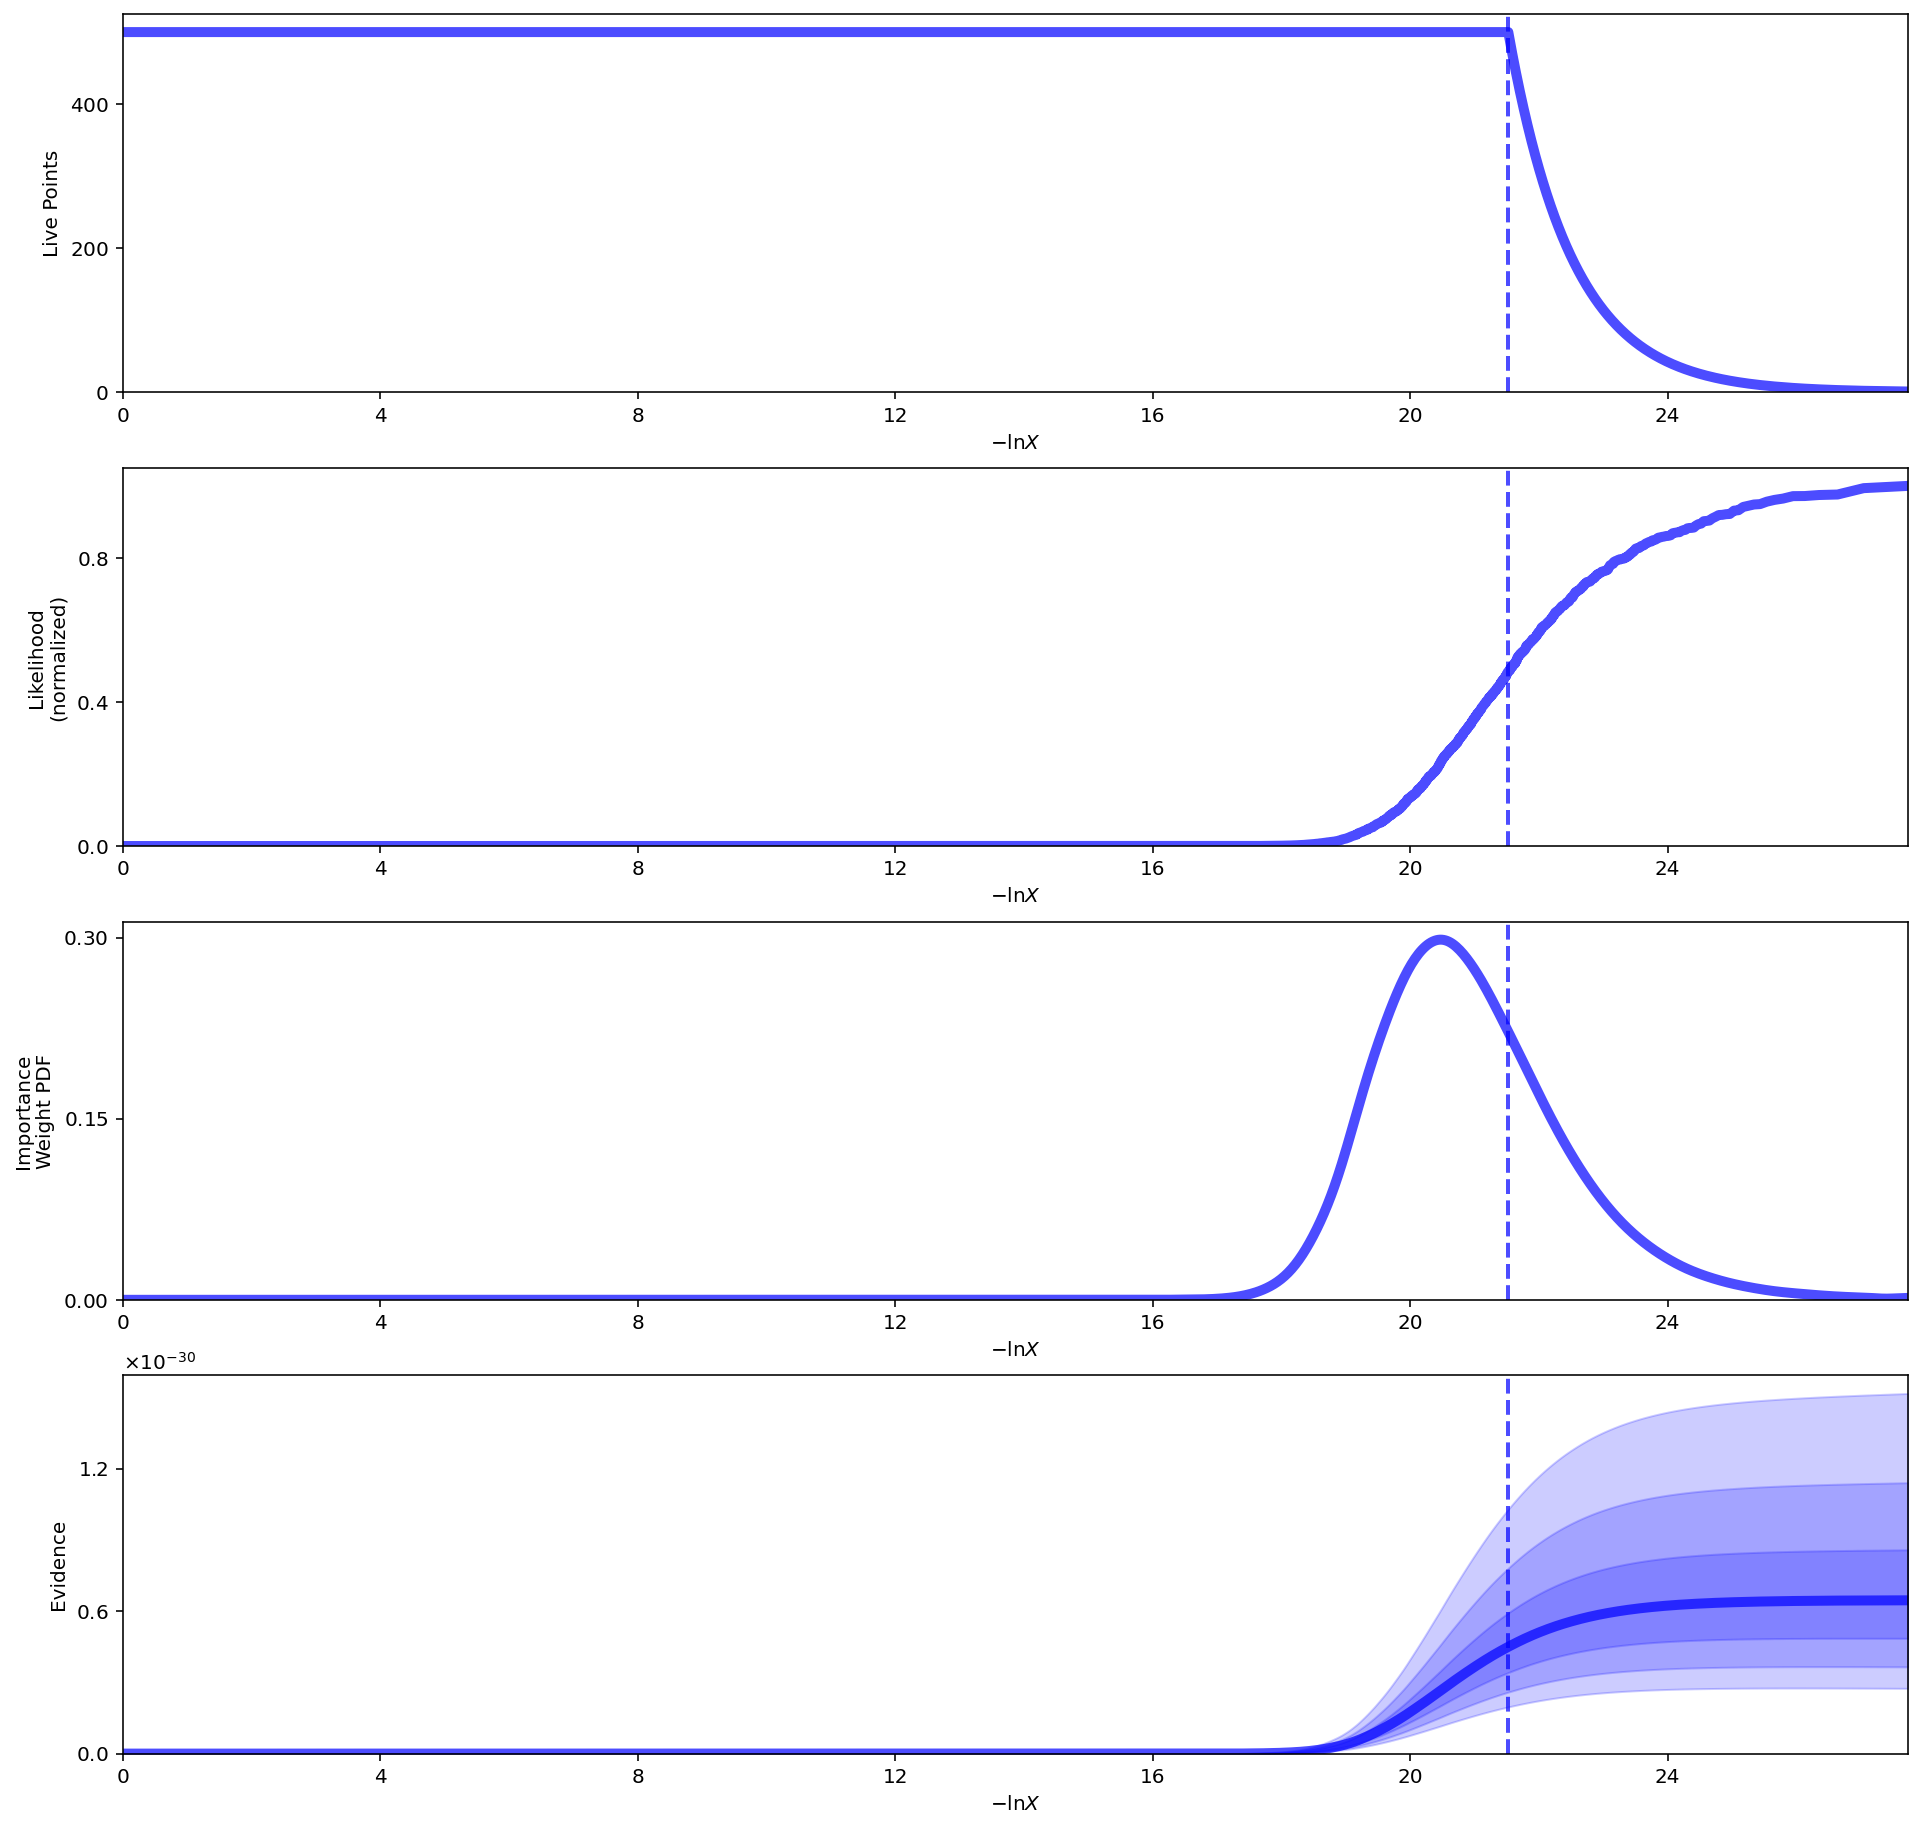

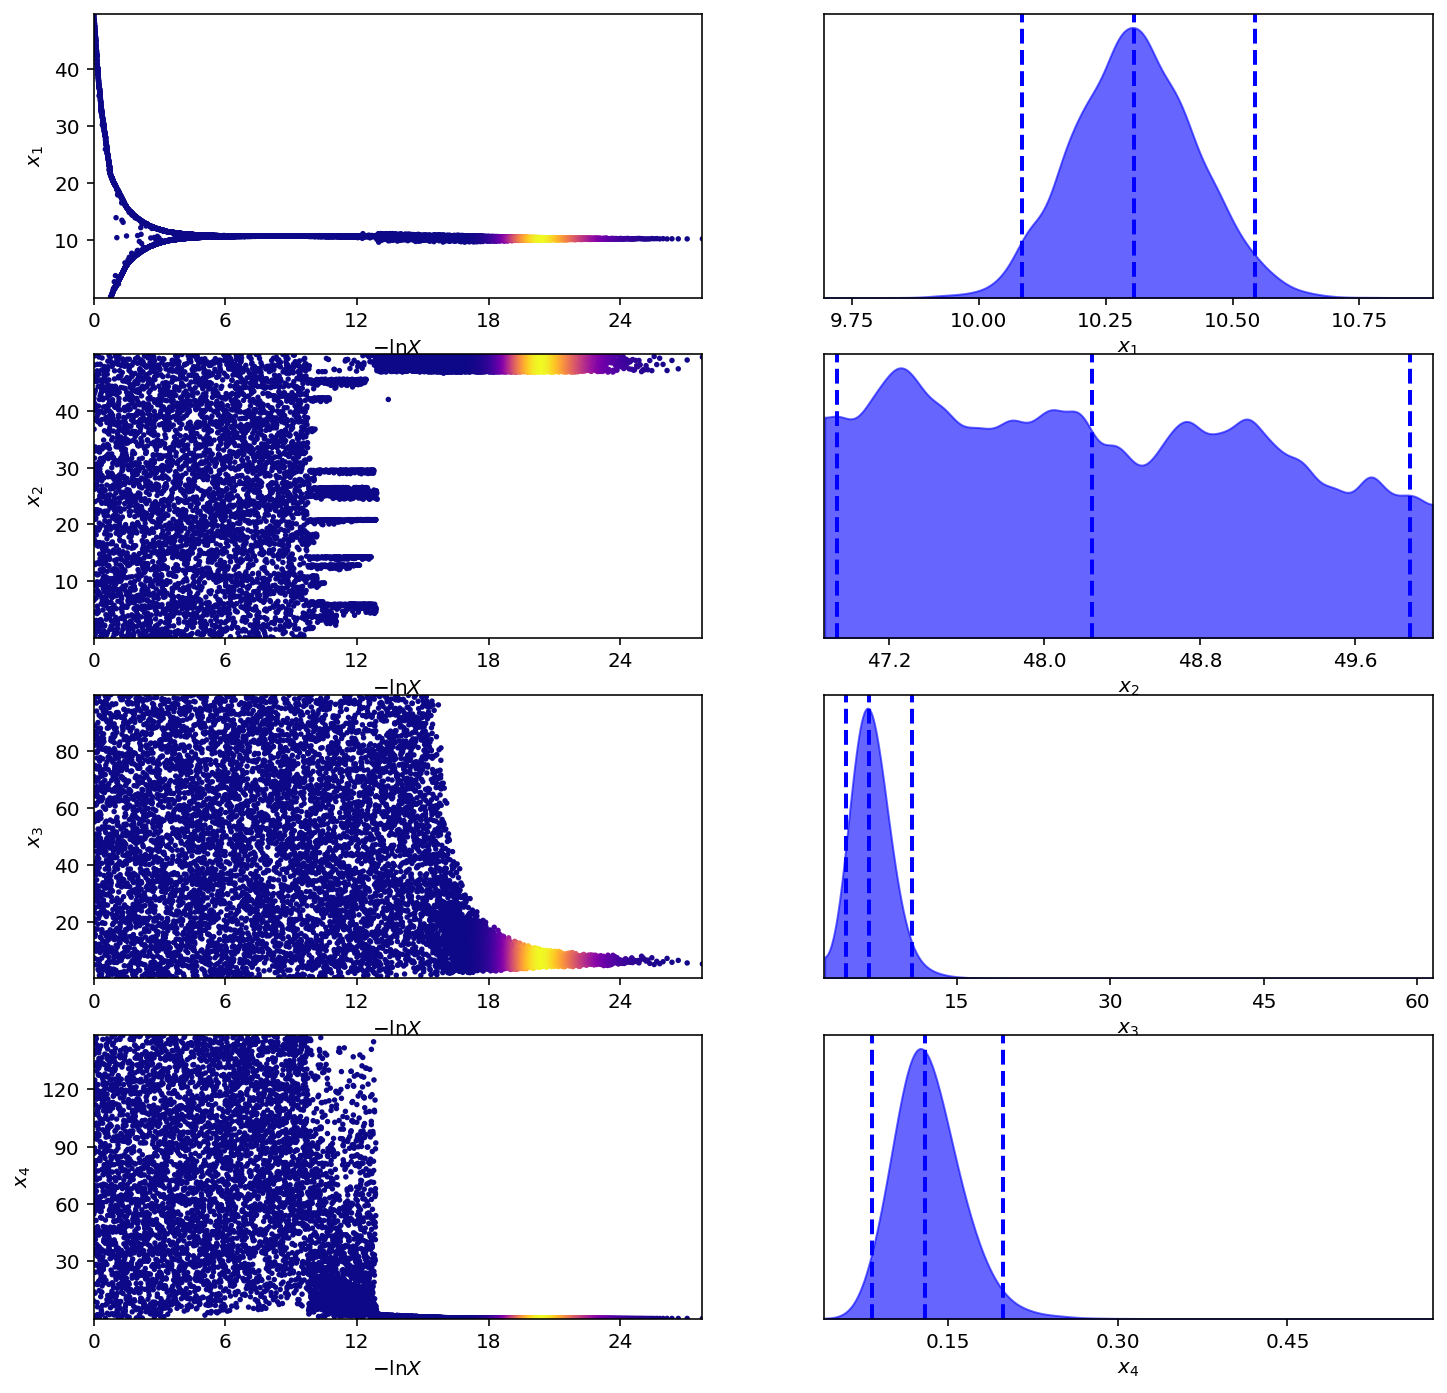

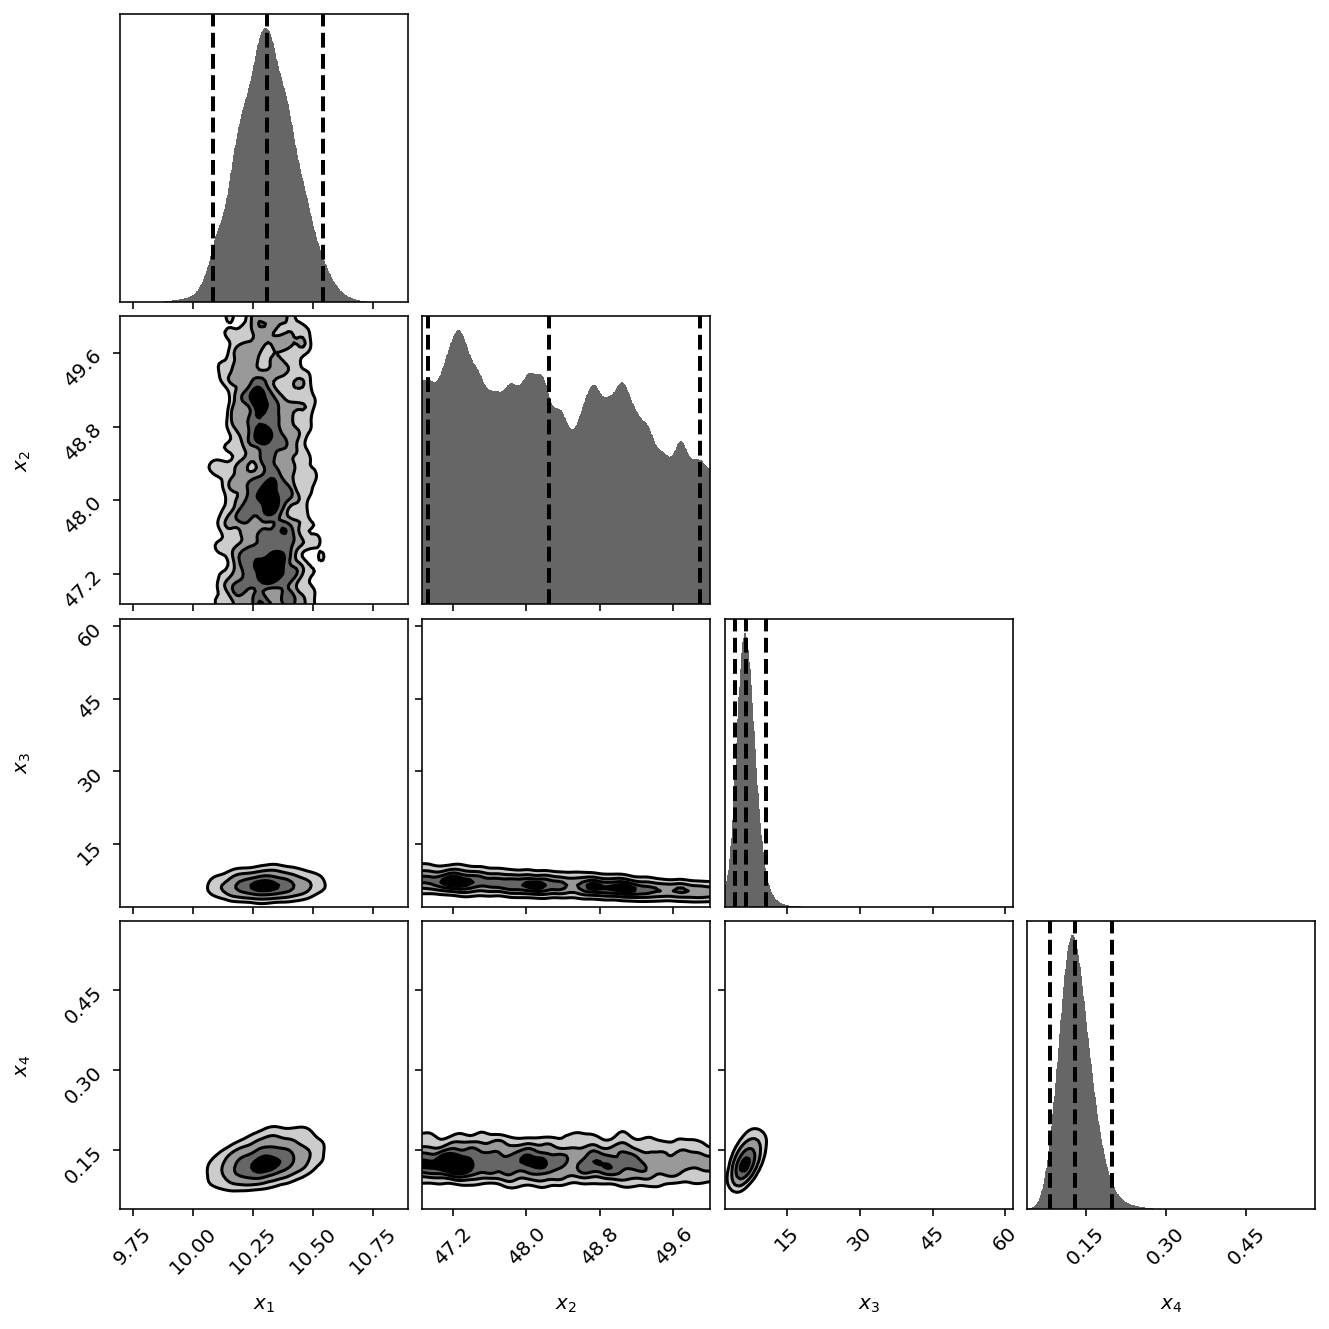

In [16]:
# BS - plot the results for the burst model

from dynesty import plotting as dyplot

# BS - print out all of the results for the burst model
sresults.summary()
rfig, raxes = dyplot.runplot(sresults)
tfig, taxes = dyplot.traceplot(sresults)
cfig, caxes = dyplot.cornerplot(sresults)

In [17]:
# BS - run the nested sampler for the Gauss model

sampler_gauss = dynesty.NestedSampler(Gauss_log_likelihood, my_prior_Gaussian, ndim, logl_args=(data, Gauss_model))
sampler_gauss.run_nested()
gresults = sampler_gauss.results

iter: 8782 | +500 | bound: 46 | nc: 1 | ncall: 52461 | eff(%): 17.693 | loglstar:   -inf < -71.742 <    inf | logz: -88.651 +/-  0.264 | dlogz:  0.001 >  0.509                                       

Summary
nlive: 500
niter: 8782
ncall: 52461
eff(%): 17.693
logz: -88.651 +/-  0.264


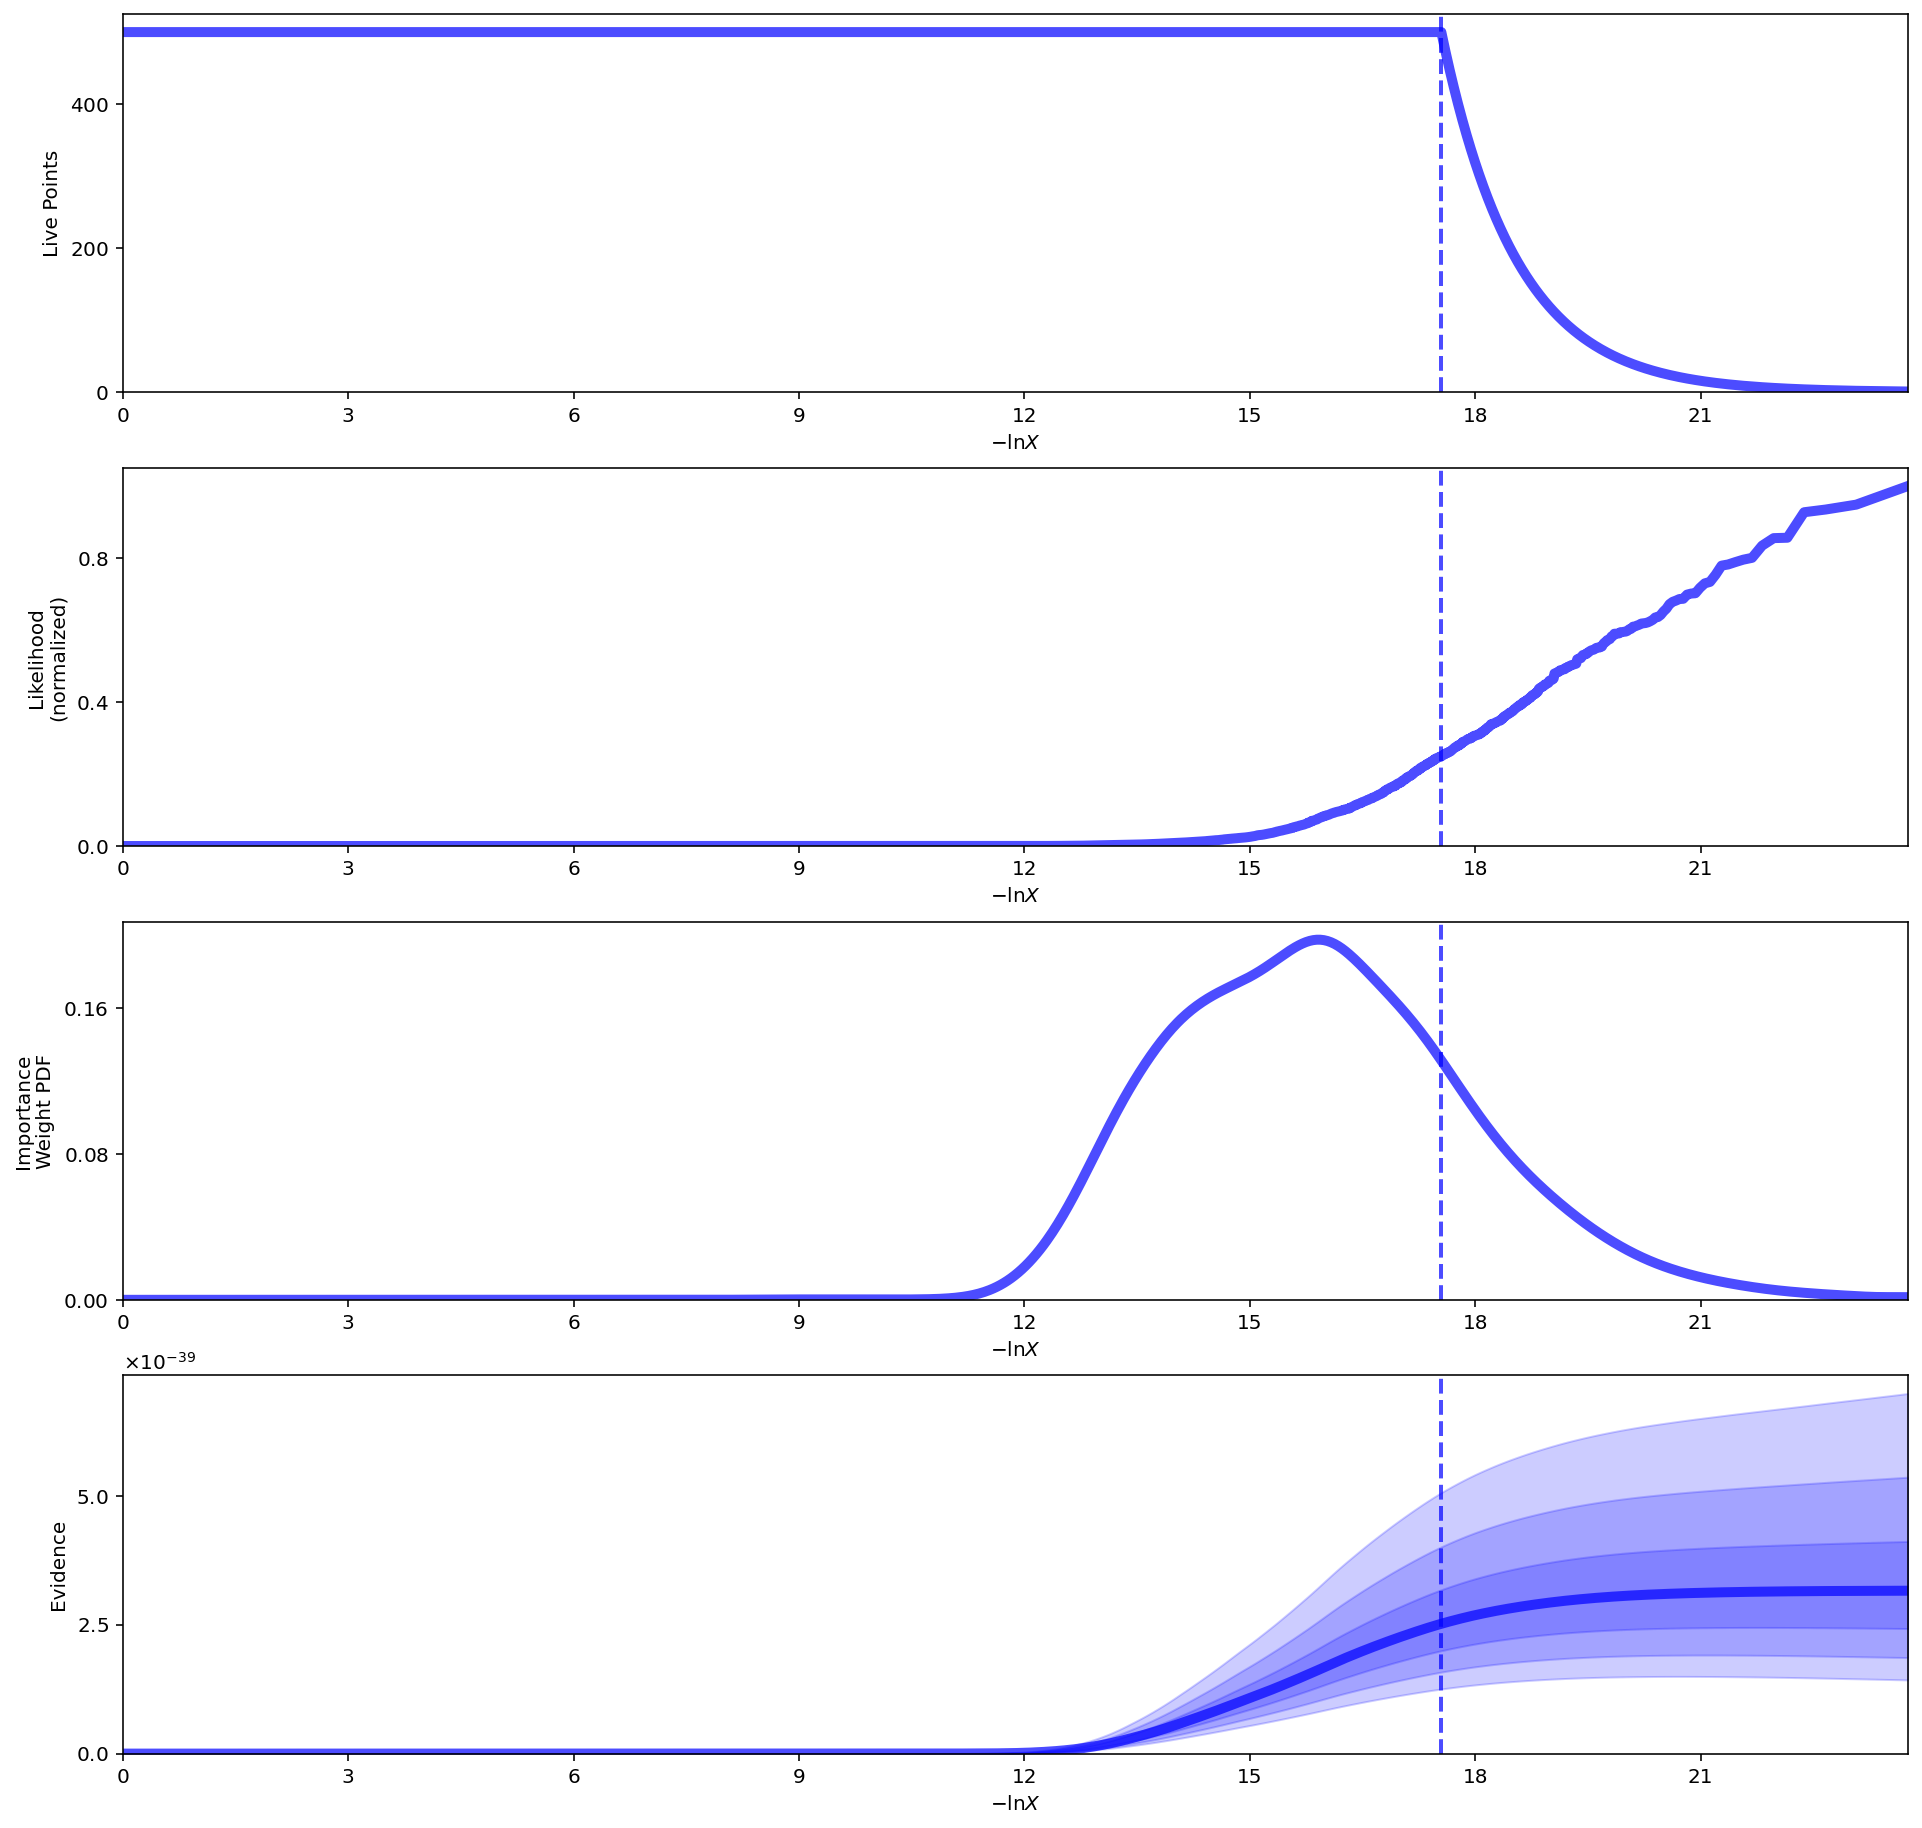

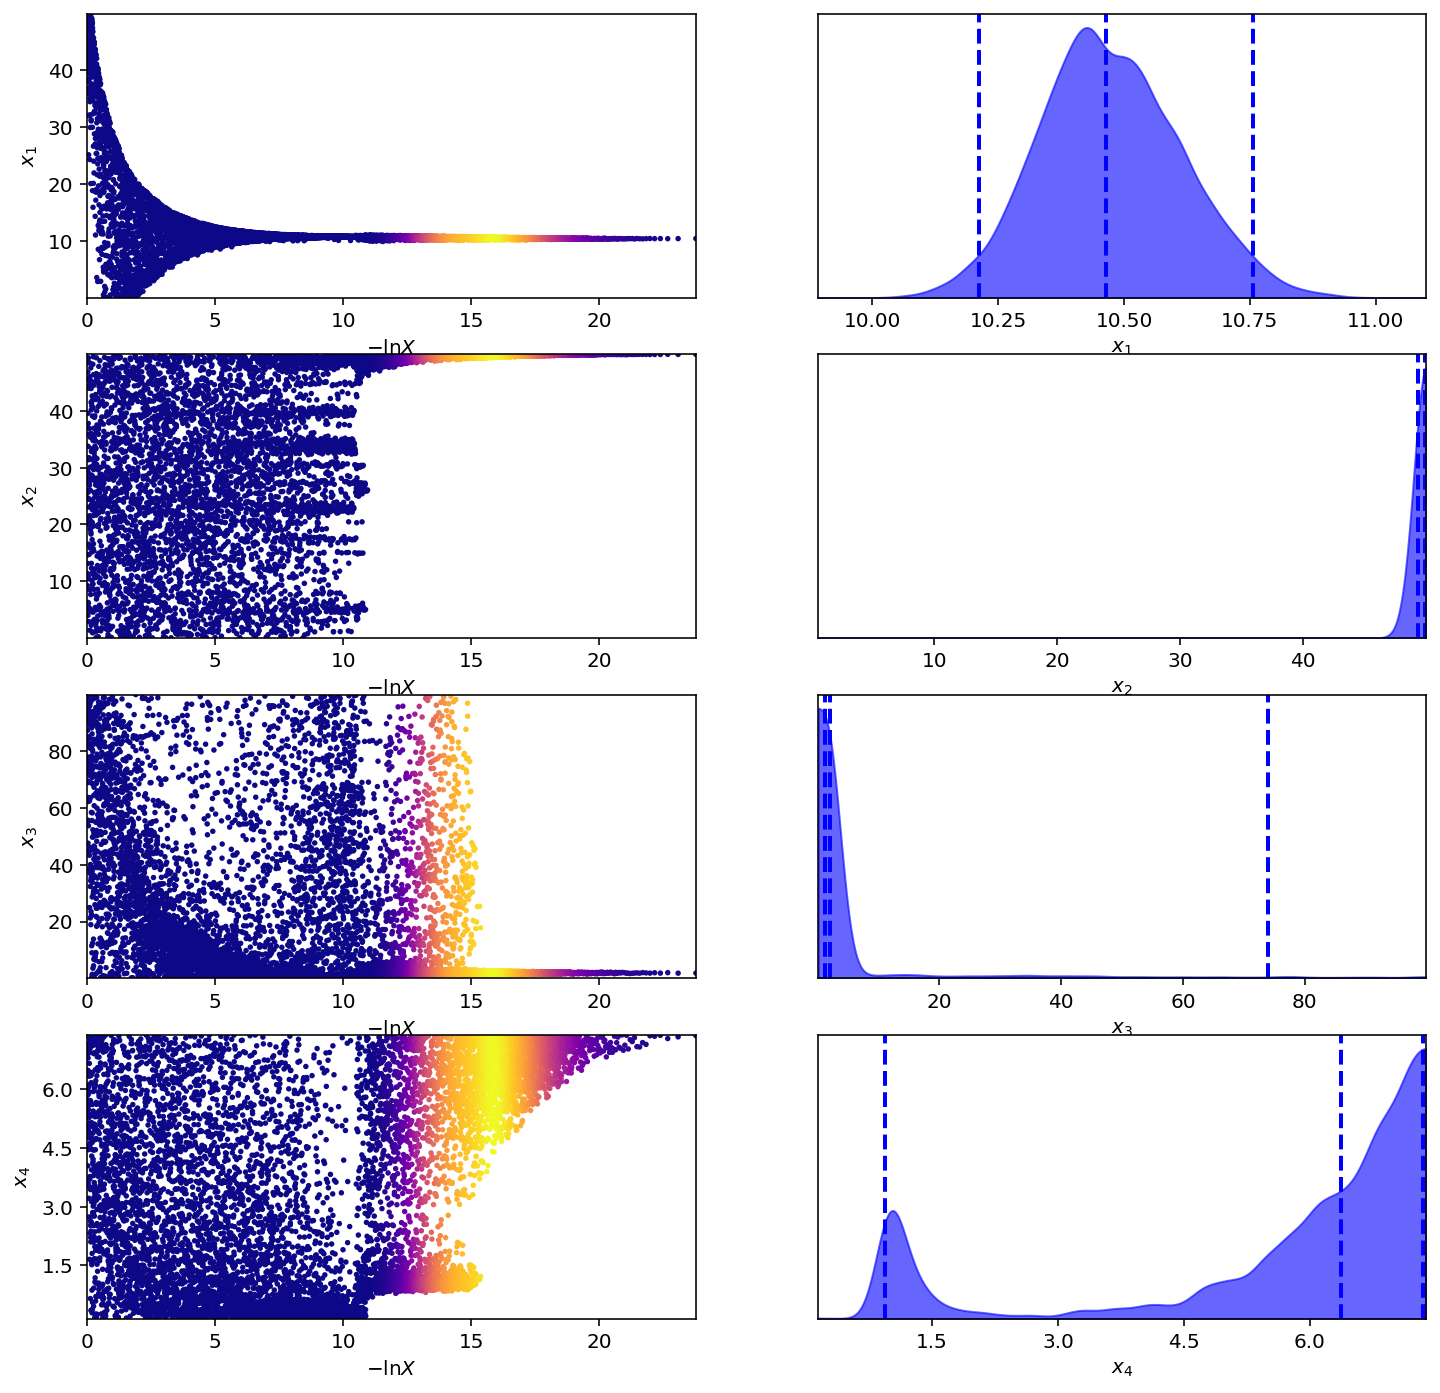

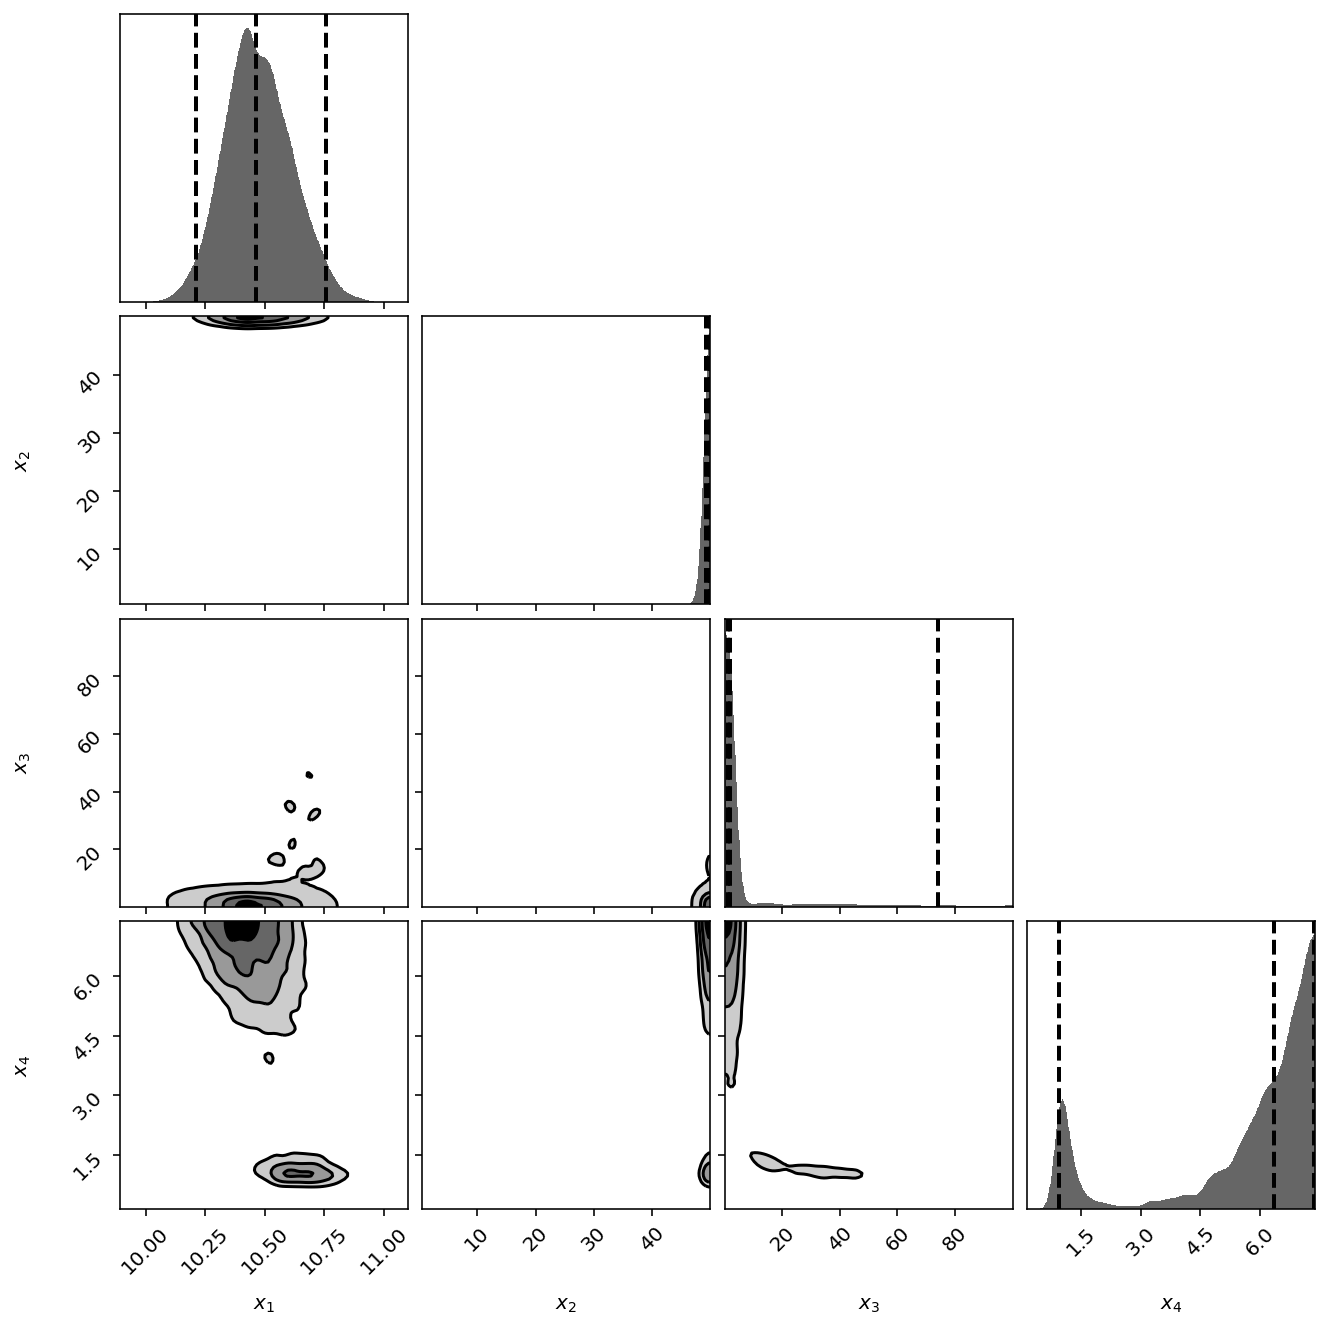

In [18]:
# BS - print out the results for the Gauss model

gresults.summary()
r2fig, r2axes = dyplot.runplot(gresults)
t2fig, t2axes = dyplot.traceplot(gresults)
c2fig, c2axes = dyplot.cornerplot(gresults)

The log of the Bayesian evidence for the burst model is $\approx -69$ and the log of the evidence for the Gauss model is $\approx -89$, so there is stronger evidence for the burst model. Additionally, I am still not sure what is going on with my Gauss model corner plots...

SRT: Your hypercube transformation was not correct in the alpha and sigmaW parameters. For example, you have implemented a prior that is uniform in alpha between exp(-5) and exp(+5), which is not the same as one that is uniform in ln(alpha); you showed above in your nice calculation that the latter should have diminishing prior support as alpha gets bigger. The same is true for sigmaW, and is likely why your posterior gets unbounded toward the edge of the prior. Both evidence values are not correct, but your overall method was solid. -3